## Project Introduction

In this project, we seek to use LLMs to translate phrases from foreign languages to English and compare them with the translation found within the dataset to ascertain the accuracy of LLM translations.

## Data Preparation

In [1]:
import pandas as pd

In [2]:
from datasets import load_dataset

dataset = load_dataset("mt_eng_vietnamese", 'iwslt2015-en-vi')

In [3]:
train_data = dataset["train"]
validation_data = dataset['validation']
test_data = dataset['test']

# Extract English and Vietnamese translations
english_translations = [sample['translation']['en'] for sample in train_data]
vietnamese_translations = [sample['translation']['vi'] for sample in train_data]

# Create DataFrame
df = pd.DataFrame({'English': english_translations, 'Vietnamese': vietnamese_translations})

print(df.head())

                                             English  \
0  Rachel Pike : The science behind a climate hea...   
1  In 4 minutes , atmospheric chemist Rachel Pike...   
2  I &apos;d like to talk to you today about the ...   
3  Headlines that look like this when they have t...   
4  They are both two branches of the same field o...   

                                          Vietnamese  
0           Khoa học đằng sau một tiêu đề về khí hậu  
1  Trong 4 phút , chuyên gia hoá học khí quyển Ra...  
2  Tôi muốn cho các bạn biết về sự to lớn của nhữ...  
3  Có những dòng trông như thế này khi bàn về biế...  
4  Cả hai đều là một nhánh của cùng một lĩnh vực ...  


## Exploratory Data Analysis

## Data Visualizations

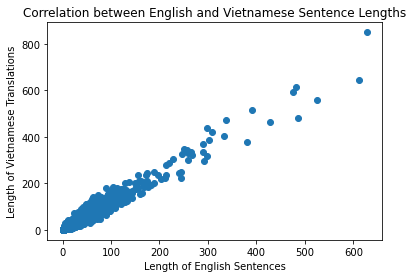

                                             English  \
0  Rachel Pike : The science behind a climate hea...   
1  In 4 minutes , atmospheric chemist Rachel Pike...   
2  I &apos;d like to talk to you today about the ...   
3  Headlines that look like this when they have t...   
4  They are both two branches of the same field o...   

                                          Vietnamese  
0           Khoa học đằng sau một tiêu đề về khí hậu  
1  Trong 4 phút , chuyên gia hoá học khí quyển Ra...  
2  Tôi muốn cho các bạn biết về sự to lớn của nhữ...  
3  Có những dòng trông như thế này khi bàn về biế...  
4  Cả hai đều là một nhánh của cùng một lĩnh vực ...  


In [4]:
import matplotlib.pyplot as plt

# Calculate lengths and add them as new columns to the DataFrame
English_Length= df['English'].apply(lambda x: len(x.split()))
Vietnamese_Length= df['Vietnamese'].apply(lambda x: len(x.split()))

# Plotting
plt.scatter(English_Length,Vietnamese_Length)
plt.xlabel('Length of English Sentences')
plt.ylabel('Length of Vietnamese Translations')
plt.title('Correlation between English and Vietnamese Sentence Lengths')
plt.show()

print(df.head())

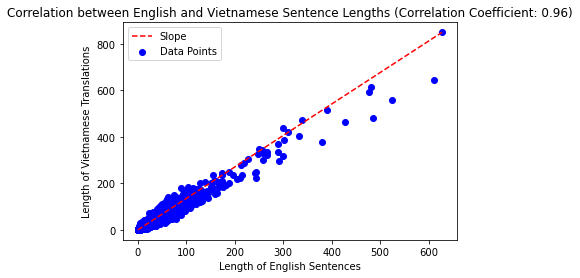

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(English_Length, Vietnamese_Length)[0, 1]

# Scatter plot with different colors for each point
plt.scatter(English_Length, Vietnamese_Length, c='blue', label='Data Points')

# Plot a line representing the slope of the correlation
plt.plot([min(English_Length), max(English_Length)], [min(Vietnamese_Length), max(Vietnamese_Length)], color='red', linestyle='--', label='Slope')

plt.xlabel('Length of English Sentences')
plt.ylabel('Length of Vietnamese Translations')
plt.title('Correlation between English and Vietnamese Sentence Lengths (Correlation Coefficient: {:.2f})'.format(correlation_coefficient))
plt.legend()
plt.show()

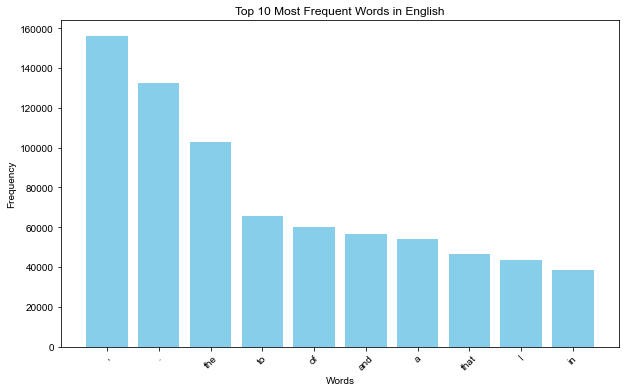

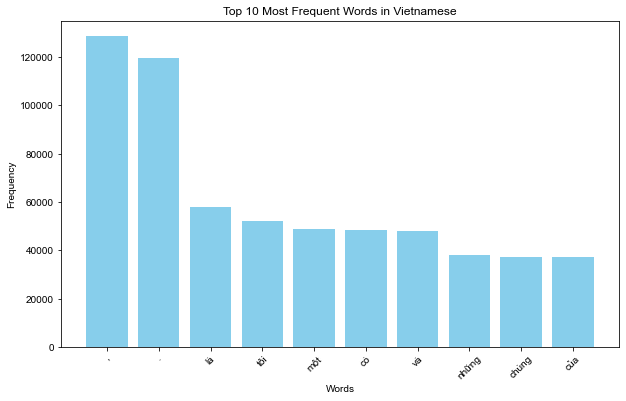

ValueError: Only supported for TrueType fonts

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Set the font globally for matplotlib
plt.rcParams['font.family'] = 'Arial'

# Preprocess data to get all English and Vietnamese words
english_words = [word for text in df['English'] for word in text.split()]
vietnamese_words = [word for text in df['Vietnamese'] for word in text.split()]

# Visualization 1: Bar plot - Top N most frequent words
def plot_top_words(word_list, language, top_n=10):
    word_counts = Counter(word_list)
    top_words = word_counts.most_common(top_n)
    plt.figure(figsize=(10, 6))
    plt.bar([word[0] for word in top_words], [count[1] for count in top_words], color='skyblue')
    plt.title(f'Top {top_n} Most Frequent Words in {language}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(english_words, 'English', top_n=10)
plot_top_words(vietnamese_words, 'Vietnamese', top_n=10)

# Visualization 2: Word cloud
def generate_wordcloud(word_list, language):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words in {language}')
    plt.axis('off')
    plt.show()

generate_wordcloud(english_words, 'English')
generate_wordcloud(vietnamese_words, 'Vietnamese')


## ML Analysis

## Reflection


## Next Steps